In [47]:
from dataclasses import dataclass, field
import multiprocessing
from collections import Counter
import enum
from functools import total_ordering, partial
from itertools import groupby

from matplotlib import pyplot as plt
import pandas as pd
import pysam
from tqdm import tqdm
from typing import Generator

In [2]:
gtf = "data/refs/homo_sapiens.annot.gtf"
truth_tsv = "output/truth/Expr1.truth.tsv"
bam_path = "output/freddie/preprocess/Expr1.sorted.bam"

In [3]:
@dataclass
class Intervals:
    contig: str = ""
    intervals: list[tuple[int, int]] = field(default_factory=list)


def get_gtf_data(gtf: str):
    transcript_intervals: dict[str, Intervals] = dict()
    for line in tqdm(open(gtf), desc=f"Reading {gtf}"):
        if line[0] == "#":
            continue
        line = line.strip("\n").split("\t")
        if not line[2] in ["exon", "transcript"]:
            continue
        info = line[8]
        info = [x.strip().split(" ") for x in info.strip(";").split(";")]
        info = {x[0]: x[1].strip('"') for x in info}
        tid = info["transcript_id"]
        contig, start, end = line[0], int(line[3]) - 1, int(line[4]) - 1
        match line[2]:
            case "transcript":
                assert tid not in transcript_intervals
                transcript_intervals[tid] = Intervals(
                    contig=contig,
                )
            case "exon":
                transcript_intervals[tid].intervals.append((start, end))
    transcript_intervals = {
        k: v for k, v in transcript_intervals.items() if len(v.intervals) > 1
    }
    return transcript_intervals

In [4]:
transcript_intervals = get_gtf_data(gtf=gtf)

Reading data/refs/homo_sapiens.annot.gtf: 3408735it [00:31, 109370.61it/s]


In [58]:
# def add_mapping_info(contig: str, bam_path: str):
#     rid_to_intervals: dict[str, Intervals] = dict()
#     for aln in tqdm(
#         pysam.AlignmentFile(bam_path).fetch(contig=contig),
#         desc=f"Reading contig {contig}",
#     ):
#         if aln.is_supplementary or aln.is_secondary or aln.is_unmapped:
#             continue
#         assert aln.query_name is not None
#         rid_to_intervals[aln.query_name] = Intervals(
#             contig=contig,
#             intervals=[
#                 (x.target.start, x.target.end)
#                 for x in split.FredSplit.get_intervals(aln, 20)
#             ],
#         )
#     return rid_to_intervals


def generate_introns(
    intervals: list[tuple[int, int]]
) -> Generator[tuple[int, int], None, None]:
    for (_, e1), (s2, _) in zip(intervals[:-1], intervals[1:]):
        yield (e1, s2)


def close_enough(t_intron, r_intron, slack=10):
    t_start, t_end = t_intron
    r_start, r_end = r_intron
    if abs(t_start - r_start) > slack:
        return False
    if abs(t_end - r_end) > slack:
        return False
    return True


def compute_intron_support(
    read, transcript_intervals: dict[str, Intervals]
) -> list[set[int]]:
    if read["transcript_id"] not in transcript_intervals:
        return list()
    t_intervals = transcript_intervals[read["transcript_id"]]
    support: list[set[int]] = [set() for _ in t_intervals.intervals[:-1]]
    if t_intervals.contig != read["contig"]:
        return support
    for support_set, t_intron in zip(support, generate_introns(t_intervals.intervals)):
        for r_intron in generate_introns(read["intervals"]):
            if close_enough(t_intron, r_intron):
                support_set.add(read.name)
                break
    return support


def aggregate_support(supports):
    L = {len(s) for s in supports}
    assert len(L) == 1
    if L == {0}:
        return 0
    total_support = [set() for _ in supports.iloc[0]]
    for support in supports:
        for S, s in zip(total_support, support):
            S.update(s)
    if min(map(len, total_support)) == 0:
        return 0
    return len(set.union(*total_support))

In [9]:
class CIGAR_OPS_SIMPLE(enum.IntEnum):
    both = 0
    target = 1
    query = 2


op_simply: dict[int, CIGAR_OPS_SIMPLE] = {
    pysam.CSOFT_CLIP: CIGAR_OPS_SIMPLE.query,
    pysam.CINS: CIGAR_OPS_SIMPLE.query,
    pysam.CDEL: CIGAR_OPS_SIMPLE.target,
    pysam.CREF_SKIP: CIGAR_OPS_SIMPLE.target,
    pysam.CMATCH: CIGAR_OPS_SIMPLE.both,
    pysam.CDIFF: CIGAR_OPS_SIMPLE.both,
    pysam.CEQUAL: CIGAR_OPS_SIMPLE.both,
}


@total_ordering
@dataclass
class Interval:
    start: int = 0
    end: int = 0

    def __post_init__(self):
        assert 0 <= self.start <= self.end

    def __eq__(self, other):
        return (self.start, self.end) == (other.start, other.end)

    def __lt__(self, other):
        return (self.start, self.end) < (other.start, other.end)

    def __le__(self, other):
        return (self.start, self.end) <= (other.start, other.end)

    def __gt__(self, other):
        return (self.start, self.end) > (other.start, other.end)

    def __ge__(self, other):
        return (self.start, self.end) >= (other.start, other.end)

    def __len__(self):
        return self.end - self.start


@dataclass
class PairedInterval:
    query: Interval = field(default_factory=Interval)
    target: Interval = field(default_factory=Interval)


@dataclass
class PairedIntervalCigar(PairedInterval):
    cigar: list[tuple[CIGAR_OPS_SIMPLE, int]] = field(default_factory=list)


def canonize_cigar(
    cigartuples: list[tuple[int, int]]
) -> list[tuple[CIGAR_OPS_SIMPLE, int]]:
    simple_cigartuples = [(op_simply[op], l) for op, l in cigartuples]
    canonized_cigar: list[tuple[CIGAR_OPS_SIMPLE, int]] = list()
    for _, g in groupby(
        simple_cigartuples, key=lambda x: x[0] == CIGAR_OPS_SIMPLE.both
    ):
        C: Counter[CIGAR_OPS_SIMPLE] = Counter()
        for op, l in g:
            C[op] += l
        for op, l in sorted(C.items()):
            if l > 0:
                canonized_cigar.append((op, l))
    return canonized_cigar


def get_intervals(
    reference_start: int,
    cigartuples: list[tuple[int, int]],
    cigar_max_del: int = 20,
) -> list[PairedInterval]:
    cigar = canonize_cigar(cigartuples)
    qstart = 0
    qlen = 0
    for op, l in cigar:
        if op in [CIGAR_OPS_SIMPLE.query, CIGAR_OPS_SIMPLE.both]:
            qlen += l

    # list of exonic intervals of the alignment
    intervals: list[PairedIntervalCigar] = list()

    qstart: int = 0  # current interval's start on query
    qend: int = 0  # current interval's end on query
    tstart: int = reference_start  # reference_start is 0-indexed
    tend: int = tstart  # current interval's end on target
    for is_splice, g in groupby(
        cigar,
        key=lambda x: x[0] == CIGAR_OPS_SIMPLE.target and x[1] > cigar_max_del,
    ):
        cur_cigar = list(g)
        for op, l in cur_cigar:
            if op == CIGAR_OPS_SIMPLE.query:
                qend += l
            elif op == CIGAR_OPS_SIMPLE.target:
                tend += l
            elif op == CIGAR_OPS_SIMPLE.both:
                qend += l
                tend += l
        if not is_splice:
            intervals.append(
                PairedIntervalCigar(
                    query=Interval(qstart, qend),
                    target=Interval(tstart, tend),
                    cigar=cur_cigar,
                )
            )
        qstart = qend
        tstart = tend
    final_intervals: list[PairedInterval] = list()
    for interval in intervals:
        qs = interval.query.start
        qe = interval.query.end
        ts = interval.target.start
        te = interval.target.end
        cigar = interval.cigar
        assert qe - qs == (
            S := sum(
                l
                for op, l in cigar
                if op in [CIGAR_OPS_SIMPLE.query, CIGAR_OPS_SIMPLE.both]
            )
        ), (qe - qs, S)
        assert te - ts == (
            S := sum(
                l
                for op, l in cigar
                if op in [CIGAR_OPS_SIMPLE.target, CIGAR_OPS_SIMPLE.both]
            )
        ), (qe - qs, S)
        for op, l in cigar:
            if op == CIGAR_OPS_SIMPLE.both:
                break
            if op == CIGAR_OPS_SIMPLE.query:
                qs += l
            elif op == CIGAR_OPS_SIMPLE.target:
                ts += l
        for op, l in cigar[::-1]:
            if op == CIGAR_OPS_SIMPLE.both:
                break
            if op == CIGAR_OPS_SIMPLE.query:
                qe -= l
            elif op == CIGAR_OPS_SIMPLE.target:
                te -= l
        final_intervals.append(
            PairedInterval(query=Interval(qs, qe), target=Interval(ts, te))
        )
    return final_intervals

In [14]:
def aln_gen(bam_path):
    for aln in tqdm(pysam.AlignmentFile(bam_path).fetch()):
        if aln.is_supplementary or aln.is_secondary or aln.is_unmapped:
            continue
        yield (aln.query_name, aln.reference_name, aln.reference_start, aln.cigartuples)


def process_aln(aln) -> tuple[str, Intervals]:
    query_name, reference_name, reference_start, cigartuples = aln
    return (
        query_name,
        Intervals(reference_name,
        [
            (x.target.start, x.target.end)
            for x in get_intervals(reference_start, cigartuples)
        ]),
    )


read_alns: dict[str, Intervals] = dict()
with multiprocessing.Pool(32) as pool:
    for read_id, aln_intervals in pool.map(process_aln, aln_gen(bam_path)):
        assert read_id not in read_alns
        read_alns[read_id] = aln_intervals

5642145it [02:40, 35148.49it/s] 


In [40]:
reads = (
    pd.read_csv(
        truth_tsv,
        sep="\t",
    )
    .drop(
        ["cell_barcode"],
        axis=1,
    )
    .fillna("N")
)
reads = reads.set_index("read_id", verify_integrity=True)
reads["contig"] = reads.apply(
    lambda x: read_alns[x.name].contig if x.name in read_alns else "",
    axis=1,
)
reads["intervals"] = reads.apply(
    lambda x: read_alns[x.name].intervals if x.name in read_alns else list(),
    axis=1,
)
reads["cell_lines"] = reads["cell_lines"].str.split(",")
reads = reads.explode("cell_lines", ignore_index=True)
reads["support"] = reads.apply(
    partial(
        compute_intron_support, transcript_intervals=transcript_intervals
    ),
    axis=1,
)


In [67]:
transcripts = reads.groupby(["transcript_id", "cell_lines"]).aggregate(
    {"support": aggregate_support}
)
transcripts = transcripts[transcripts["support"] >= 3].reset_index()
transcripts = (
    transcripts.pivot(
        index="transcript_id",
        columns="cell_lines",
        values="support",
    )
    .fillna(0)
    .astype(int)
    .reset_index()
    .rename_axis(None)
    .rename_axis(None, axis=1)
)
transcripts["contig"] = transcripts["transcript_id"].apply(
    lambda x: transcript_intervals[x].contig
)
transcripts["intervals"] = transcripts["transcript_id"].apply(
    lambda x: ",".join(f"{s}-{e}" for s, e in transcript_intervals[x].intervals)
)

In [69]:
transcripts.to_csv("output/post/Expr1/NEW_truth.tsv", sep="\t", index=False)


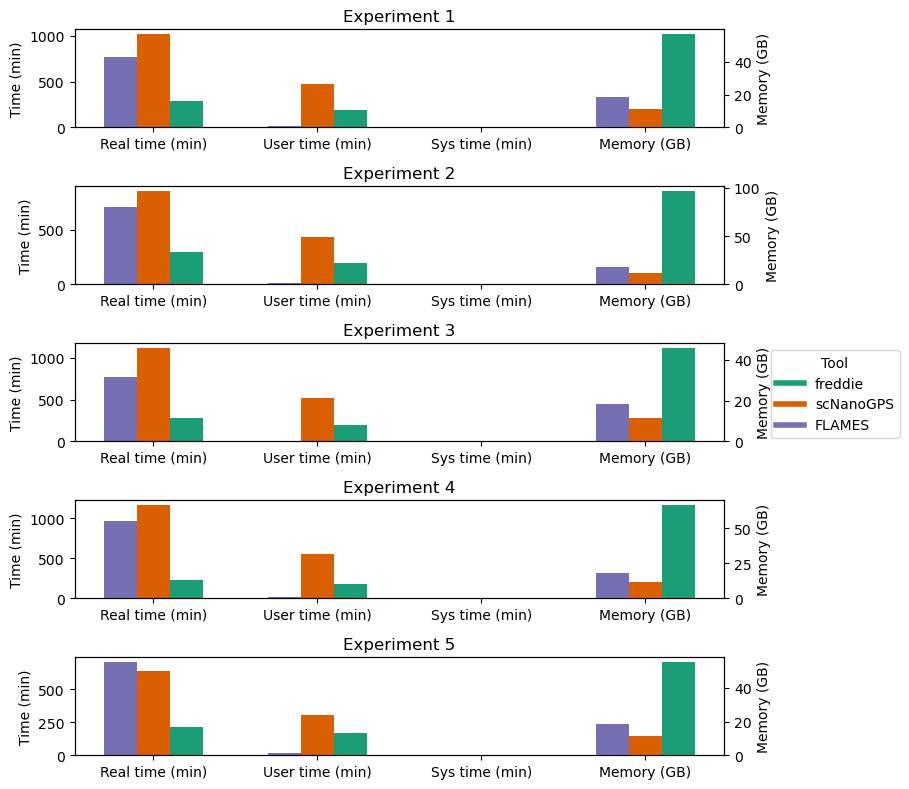

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(8, 8))


for idx in range(1, 6):
    exprmt = f"Expr{idx}"
    ax = axes[idx - 1]
    all_tools_df = pd.DataFrame()
    for tool in ["freddie", "scNanoGPS", "FLAMES"]:
        A = pd.read_csv(f"output/{tool}/time.tsv", sep=",").drop(columns=["stamp"])
        A = A[(A["sample"] == exprmt) | (A["sample"] == f"{exprmt}_r1.00")]
        A["tool"] = tool
        A["Expr"] = exprmt
        A = (
            A.groupby(["tool", "Expr"])
            .agg(
                {
                    "real_min": "sum",
                    "user_min": "sum",
                    "sys_min": "sum",
                    "mem_GB": "max",
                    "threads": "max",
                }
            )
            .reset_index()
        )
        all_tools_df = pd.concat([all_tools_df, A])
    # Plot all user time for each tools in bars bunched up by each other
    ax_mem = ax.twinx()
    for x, datum in enumerate(
        [
            "real_min",
            "user_min",
            "sys_min",
        ]
    ):
        ax.bar(
            x + 1 + 0.2,
            all_tools_df[all_tools_df["tool"] == "freddie"][datum].values[0],
            width=0.2,
            label="freddie",
            color="#1b9e77",
        )
        ax.bar(
            x + 1 + 0.0,
            all_tools_df[all_tools_df["tool"] == "scNanoGPS"][datum].values[0],
            width=0.2,
            label="scNanoGPS",
            color="#d95f02",
        )
        ax.bar(
            x + 1 - 0.2,
            all_tools_df[all_tools_df["tool"] == "FLAMES"][datum].values[0],
            width=0.2,
            label="FLAMES",
            color="#7570b3",
        )
    datum = "mem_GB"
    x = 3
    ax_mem.bar(
        x + 1 + 0.2,
        all_tools_df[all_tools_df["tool"] == "freddie"][datum].values[0],
        width=0.2,
        label="freddie",
        color="#1b9e77",
    )
    ax_mem.bar(
        x + 1 + 0.0,
        all_tools_df[all_tools_df["tool"] == "scNanoGPS"][datum].values[0],
        width=0.2,
        label="scNanoGPS",
        color="#d95f02",
    )
    ax_mem.bar(
        x + 1 - 0.2,
        all_tools_df[all_tools_df["tool"] == "FLAMES"][datum].values[0],
        width=0.2,
        label="FLAMES",
        color="#7570b3",
    )

    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(
        ["Real time (min)", "User time (min)", "Sys time (min)", "Memory (GB)"]
    )
    ax.set_title(f"Experiment {idx}")
    ax.set_ylabel("Time (min)")
    ax_mem.set_ylabel("Memory (GB)")
    # Then all real time for each tools in bars by each other
    # Then all sys time for each tools in bars by each other
# One legend for all the plots
labels = ["freddie", "scNanoGPS", "FLAMES"]
colors = ["#1b9e77", "#d95f02", "#7570b3"]
fig.legend(
    [plt.Line2D([0], [0], color=c, lw=4) for c in colors],
    labels,
    loc="center",
    title="Tool",
    bbox_to_anchor=(1.05, 0.5),
    ncol=1,
)
fig.tight_layout()